In [7]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# nltk.download('all')

In [8]:
#Import the data set
df = pd.read_csv('amazon.csv')
#Make sure it was read right
df.head(10)

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1
5,This is a very entertaining game! You don't h...,1
6,this is awesome and you don't need wi ti to pl...,1
7,this is awesome I bet no one even reads the re...,1
8,This is basicly the free version but with ads....,1
9,this is by far the best free app that is avail...,1


In [10]:
#Crate a function to preprocess text

def preprocess_text(text):
    #Additional steps

    #Remove all punctuation:
    text = re.sub(r"[^\w\s]", " ", text)

    #Normalize spaces
    text = " ".join(text.split())

    # Tokenize with word_tokenize
    tokens = word_tokenize(text)

    # Change all to lowercase
    tokens = [token.lower() for token in tokens]

    # delete all stop words with stopwords.words()
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lematize the ords using WordNetLemmatizer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    #paste all tokens back together
    rejoined_text = " ".join(tokens)

    # Return the processed text
    return rejoined_text

# Apply the function to the df

df['clean'] = df['reviewText'].apply(preprocess_text)

In [12]:
df[['reviewText', 'clean']].head()

,reviewText,clean
0,This is a one of the best apps acording to a b...,one best apps acording bunch people agree bomb...
1,This is a pretty good version of the game for ...,pretty good version game free lot different le...
2,this is a really cool game. there are a bunch ...,really cool game bunch level find golden egg s...
3,"This is a silly game and can be frustrating, b...",silly game frustrating lot fun definitely reco...
4,This is a terrific game on any pad. Hrs of fun...,terrific game pad hr fun grandkids love great ...


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Get the X and y
X = df['clean']
y = df['Positive']

# The X and y are already encoded

# Partition the dataset into training, validation and testing:
texts_train, texts_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
texts_val, texts_test, y_val, y_test = train_test_split(texts_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
#Here we are looking at the feature
X.describe()

count     20000
unique    19994
top        like
freq          3
Name: clean, dtype: object

In [19]:
df['clean_word_len'] = X.str.split().str.len()
df['clean_word_len'].describe() 

count    20000.000000
mean        16.798500
std          5.855742
min          0.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         42.000000
Name: clean_word_len, dtype: float64

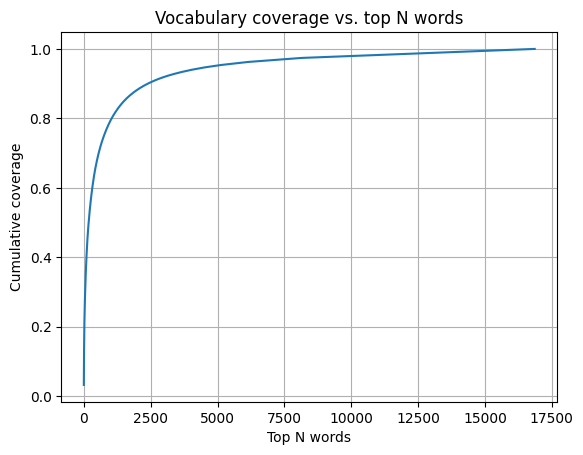

In [20]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize all texts
all_tokens = ' '.join(df['clean']).split()
word_counts = Counter(all_tokens)

# Plot cumulative coverage
counts = sorted(word_counts.values(), reverse=True)
cumulative = [sum(counts[:i]) / sum(counts) for i in range(1, len(counts))]
plt.plot(cumulative)
plt.xlabel("Top N words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary coverage vs. top N words")
plt.grid(True)
plt.show()


In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_words = 5000
max_len = 50

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(texts_train)
sequences_train = tok.texts_to_sequences(texts_train)
sequences_val = tok.texts_to_sequences(texts_val)
sequences_test = tok.texts_to_sequences(texts_test)
sequences_matrix_train = pad_sequences(sequences_train, maxlen=max_len)
sequences_matrix_val = pad_sequences(sequences_val,maxlen=max_len)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)


In [38]:

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN

# Define your model

def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64, return_sequences=False)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


In [39]:
# Make an instance of your model
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 50, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,505 (1.07 MB)

 Trainable params: 279,505 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:

# Train yor model
history = model.fit(sequences_matrix_train, y_train, validation_data=(sequences_matrix_val, y_val), epochs=10, batch_size=16, verbose=1)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8581 - loss: 0.3348 - val_accuracy: 0.8833 - val_loss: 0.2907
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9255 - loss: 0.1964 - val_accuracy: 0.8880 - val_loss: 0.2852
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9458 - loss: 0.1440 - val_accuracy: 0.8803 - val_loss: 0.3111
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9605 - loss: 0.1130 - val_accuracy: 0.8777 - val_loss: 0.4016
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9681 - loss: 0.0898 - val_accuracy: 0.8803 - val_loss: 0.3984
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9720 - loss: 0.0765 - val_accuracy: 0.8790 - val_loss: 0.4730
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9785 - loss: 0.0580 - val_accuracy: 0.8783 - val_loss: 0.5203
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9824 - loss: 0.0511 - val_accuracy: 0

In [41]:
# Evaluate the model

accr = model.evaluate(sequences_matrix_test, y_test)
print(f"Test accuracy: {accr[1]:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8703 - loss: 0.7414
Test accuracy: 0.8703


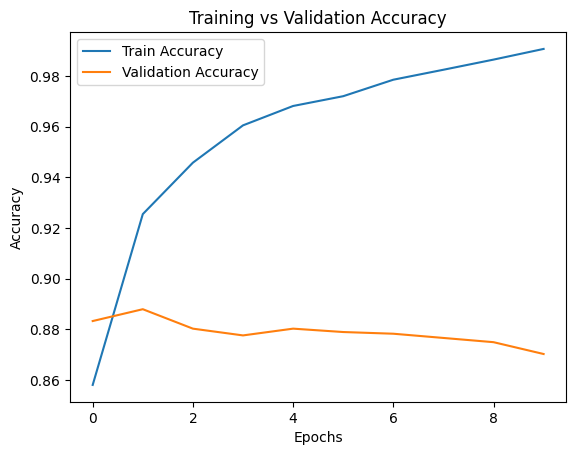

In [42]:
# Make a results graph

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()